# Import Core Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join

from tqdm import tqdm

## Define Methods to be Used

In [2]:
def calc_sec(time):
    hms = time.split(':')
    hms = [float(x) for x in hms]
    sec = hms[2] + hms[1]*60 + hms[0]*3600
    sec = round(sec,3)
    return sec

In [3]:
def calc_ts(sec):
    ts = ''
    hr = int(sec/3600)
    mn = int((sec - (hr*3600))/60)
    sc = sec - (hr*3600) - (mn*60)
    sc = round(sc,3)
    ts += str(hr) + ':' + str(mn) + ':' + str(sc)
    # print(ts)
    return ts

In [4]:
def calc_t_period(dates,secs):
    t_period = []
    
    start_sec = secs[0]
    prev_sec = secs[0]
    prev_date = dates[0]

    for i in range(len(secs)):
        curr_sec = secs[i]
        diff_sec = curr_sec - prev_sec
        curr_date = dates[i]
        
        if((diff_sec>3.0) and (curr_date==prev_date)):
            t_period.append([curr_date,start_sec,prev_sec])
            start_sec = curr_sec
        elif(curr_date!=prev_date):
            t_period.append([prev_date,start_sec,prev_sec])
            start_sec = curr_sec
            prev_date = curr_date
        elif(i==len(secs)-1):
            t_period.append([curr_date,start_sec,curr_sec])

        prev_sec = curr_sec
    
    return t_period

In [5]:
def equation_bai(X_i):
    all_std = []
    
    std_i = np.std(X_i,axis=0)
    diff_std = std_i**2 - std_i_bar**2
    diff_std = (diff_std + 1) / (std_i_bar**2 + 1)
    
    diff_std_ = std_i**2

    all_std.append(diff_std)
    
    all_std = np.array(all_std)
    
    ai = np.sum(all_std**2,axis=1)/3
    ai[ai<0] = 0
    ai = np.sqrt(ai)
    
    return ai

In [6]:
std_i_bar = [0.00349329,0.00465817,0.00543154]
std_i_bar = np.array(std_i_bar)

# Load Dataset

In [7]:
# Retrieve file directories from Google Drive
mypath = 'DDC_Data/'
basepath = ''

dir_ = [f for f in walk(mypath)]
# print(dir_)

dir = list(dir_[0])
dir[1] = sorted(dir[1])

outer_path = dir[0]
sub_path = dir[1]

folders = [join(outer_path,d) for d in sub_path]

files = []
for fd in folders:
    temp_f = [f for f in listdir(fd) if isfile(join(fd, f)) and f[-3:]=='csv' and f[5:9]!='data' and f[:4]==fd[-4:]]
    temp_f = sorted(temp_f)

## Retrieve All Timestamp Periods from a File

In [8]:
all_subjects = []

for i in range(1001,1009):
    all_subjects.append(str(i))

for i in range(2001,2003):
    all_subjects.append(str(i))

print(all_subjects)

['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '2001', '2002']


### Identify Subject ID

In [9]:
def identify_subj_id(i):
    subject_id = all_subjects[i]

    directory = basepath + 'Graphs/' + subject_id

    if(not os.path.exists(directory)):
        os.makedirs(directory)

    return subject_id  

In [10]:
def load_timer(subject_id):
  # Configure starting and ending time values
    sid_dir = mypath + '/' + subject_id
    sid_files = [f for f in listdir(sid_dir) if f[5:11]=='iphone']

    sid_filepath = sid_dir + '/' + sid_files[0]

    # Timestamp periods dataframe
    timer_df = pd.read_csv(sid_filepath, header=None, names=['sid','label', 'timestamp', 'duration'])

    filtered_timer = [i for i in timer_df['sid'] if i==int(subject_id)]

    timer_filt = timer_df[timer_df['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)

    start_ts = timer_filt.loc[0]['timestamp']
    end_ts = timer_filt.loc[len(timer_filt)-1]['timestamp']

    rec_date = start_ts[:10]
    start_time = start_ts[11:]
    end_time = end_ts[11:]

    return timer_filt, rec_date, start_time, end_time

## Create Pandas DataFrame

In [11]:
def load_acc(subject_id):
    # Load accelerations
    acc_filepath = mypath + '/' + subject_id + '/' + subject_id + '-log_acc.csv'

    df = pd.read_csv(acc_filepath, header=None, names=['x','y','z','timestamp'])

    filtered = [i for i in df['timestamp'] if i[:10]==rec_date and calc_sec(i[11:])>=calc_sec(start_time) 
              and calc_sec(i[11:])<=calc_sec(end_time)]

    df_filt = df[df['timestamp'].isin(filtered)]
    df_filt = df_filt.reset_index(drop=True)

    cols = ['timestamp','x','y','z']
    df_filt = df_filt[cols]

    return df_filt

In [12]:
def load_hr(subject_id):
    # Load heart rate
    hr_filepath = mypath + '/' + subject_id + '/' + subject_id + '-log_hr.csv'

    df2 = pd.read_csv(hr_filepath, header=None, names=['hr','timestamp'])

    filtered = [i for i in df2['timestamp'] if i[:10]==rec_date and calc_sec(i[11:])>=calc_sec(start_time) 
              and calc_sec(i[11:])<=calc_sec(end_time)]

    df_hr = df2[df2['timestamp'].isin(filtered)]
    df_hr = df_hr.reset_index(drop=True)

    cols = ['timestamp','hr']
    df_hr = df_hr[cols]

    return df_hr

In [13]:
def preprocess_ai_data(df_filt, df_hr):
    # Fill in missing HRs
    hr_cnt = 0

    for i in range(len(df_filt)):
        hr_time = df_hr.loc[hr_cnt,'timestamp'].split(' ')[1]
        filt_time = df_filt.loc[i,'timestamp'].split(' ')[1]

        if(calc_sec(hr_time)<=calc_sec(filt_time)):
            if(hr_cnt<len(df_hr)-1):
                hr_cnt += 1
        df_filt.loc[i,'HR'] = df_hr.loc[hr_cnt,'hr']

    # Normalize by dividing by g (standard gravity)
    g = 9.8
    df_filt.loc[:,'x'] = df_filt['x'].apply(lambda x: x/g)
    df_filt.loc[:,'y'] = df_filt['y'].apply(lambda x: x/g)
    df_filt.loc[:,'z'] = df_filt['z'].apply(lambda x: x/g)

    return df_filt

# Calculate Activity Index

In [14]:
def calc_ai(df1):
    H = 10
    ai1 = []

    for i in range(len(df1)):
        xyz_val = []
        if(i-H>=0):
            for j in range(H,0,-1):
                xyz_val.append([df1.iloc[i-j,1],df1.iloc[i-j,2],df1.iloc[i-j,3]])
            ai_val = float(equation_bai(xyz_val))
            ai1.append(ai_val)
        else:
            ai1.append(1)

    return ai1

## Colors for Each Acitivity

In [15]:
def prepare_time_periods(timer_filt):
    t_ = [calc_sec(t.split(' ')[1]) for t in timer_filt['timestamp']]
    duration = [d for d in timer_filt['duration']]
    lb_ = [lb for lb in timer_filt['label']]

    t_end = [t_[i]+calc_sec(duration[i]) for i in range(len(t_))]  

    ts_ = []
    labels = []

    for i in range(len(t_)):
        ts_.append(calc_sec(duration[i]))
        labels.append(lb_[i])
        if(i+1<len(t_)-1):
            ts_.append(round(t_[i+1]-t_end[i],3))
            labels.append('NaN')

    return ts_, labels

In [16]:
def prepare_color_labels(ts_, labels):
  
    accum = 0
    ts = []
    for x in ts_:
        accum += x
        ts.append(round(accum,3))

    lb_set = set()
    for x in labels:
        lb_set.add(x)

    lb_ = list(lb_set)

    set_cnt = []
    for i in range(len(lb_)):
        set_cnt.append(0)

    lb = []
    lb.append('NaN')

    for x in labels:
        for i in range(len(lb_)):
            if(lb_[i]==x and set_cnt[i]!=1 and lb_[i]!='NaN'):
                set_cnt[i] = 1
                lb.append(x)

    colors = ['#808080', '#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
            '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#008080', '#E6BEFF', 
            '#9A6324', '#800000', '#AAFFC3', '#808000', '#000075']

    color_dict = {}
    for i in range(len(lb)):
        color_dict[lb[i]] = colors[i]

    #   print(color_dict)

    lb_color = []
    for x in labels:
        lb_color.append(color_dict[x])

    return ts, lb_color

## Plot Acc, AI with Colors

In [17]:
def plot_ai(df1, ts, lb_color):
    dict1 = df1.to_dict(orient='list')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
    fig.tight_layout()

    ts_cnt = 0
    x_axis = []
    y_ai = []

    ax = axes[0]
    ax.plot(dict1['x'],color='r',label='X')
    ax.plot(dict1['y'],color='g',label='Y')
    ax.plot(dict1['z'],color='b',label='Z')
    ax.legend(loc='upper right')
    ax.set_title('X,Y,Z')

    ax = axes[1]
    for i in range(len(dict1['timestamp'])):
        if(dict1['AI'][i]>0):
            if(calc_sec(dict1['timestamp'][i].split(' ')[1])>calc_sec(start_time)+ts[ts_cnt]):
                ax.plot(x_axis,y_ai,color=lb_color[ts_cnt])
                ts_cnt += 1
                x_axis = []
                y_ai = []

            elif(ts_cnt==len(lb_color)-1):
                ax.plot(x_axis,y_ai,color=lb_color[ts_cnt])

            x_axis.append(i)
            y_ai.append(dict1['AI'][i])

    ax.set_title('Activity Index')

    # ax = axes[2]
    # ax.plot(dict1['HR'],label='HR')
    # ax.set_ylim(bottom=30,top=110)
    # ax.legend(loc='upper right')
    # ax.set_title('Heart Rate')

    fig.savefig(basepath + 'Graphs/' + subject_id + '/' + subject_id + '_ddc_run.png', dpi = 300)

    #   plt.show()
    plt.close(fig)

# AI Function

In [18]:
def ai(subject_id):
    df_filt = load_acc(subject_id)
    df_hr = load_hr(subject_id)

    df1 = preprocess_ai_data(df_filt, df_hr)
    ai1 = calc_ai(df1)

    df1['AI'] = pd.Series(ai1)

    ts_, labels = prepare_time_periods(df_timer)
    ts, lb_color = prepare_color_labels(ts_, labels)

    #   print(ts_, lb_color)

    return df1, ai1, ts, lb_color

# Separate by Labels of Activity

In [19]:
class period:
    def __init__(self, s, f):
        self.s = s
        self.f = f

In [20]:
def separate_label(df1, df_timer, df_list, labels):
  
    df_label = df_timer.groupby('label')
    td_col = ['timestamp','duration']

    for x in df_label:
    # x[0] is a label
    # x[1] is a groupby object

        df_label_x = df_label.get_group(x[0])
        df_label_x = df_label_x.reset_index(drop=True)

        temp_ts = [period(df_label_x.loc[a]['timestamp'].split(' ')[1], 
                    calc_ts( calc_sec(df_label_x.loc[a]['timestamp'].split(' ')[1])+calc_sec(df_label_x.loc[a]['duration']) )) 
                    for a in range(len(df_label_x))]

        for a in temp_ts:
            filter_ = [i for i in df1['timestamp'] 
                    if calc_sec(i.split(' ')[1])>=calc_sec(a.s) and calc_sec(i.split(' ')[1])<=calc_sec(a.f)]

            df1_new = df1[df1['timestamp'].isin(filter_)]
            df1_new = df1_new.reset_index(drop=True)

            for i in range(len(labels)):
                if(labels[i]==x[0]):
                    df_list[i] = df_list[i].append(df1_new)

    return df_list    

## Dataframe List Grouped by Label

In [21]:
def group_dataframe(df1, df_timer):
    df_list = []
    cols = ['timestamp','x','y','z','HR','AI']

    lbl = set()
    for tm in range(len(df_timer)):
        lbl.add(df_timer.loc[tm]['label'])

    LABELS = sorted(list(lbl))

    # dictionary mapped from activity label to index
    label_dict = {
      'downstairs': 0,
      'sit': 1,
      'sleep': 2,
      'stand': 3,
      'upstairs': 4,
      'walk': 5
    }

    for i in range(len(LABELS)):
        df_null = pd.DataFrame(columns=cols)
        df_null = df_null.fillna(0)

        df_list.append(df_null)

    df_list = separate_label(df1, df_timer, df_list, LABELS)

    for i in range(len(df_list)):
        df_list[i] = df_list[i].reset_index(drop=True)

    return df_list, label_dict

## Show Plots of Grouped Dataframe

In [22]:
def plot_grouped_df(df_list, label_dict):
    xyz = ['x','y','z']
    xyz_color = ['r','g','b']

    for x in label_dict:
    #     print(label_dict[x])

        figure = plt.figure(figsize=(20,6))
        figure.tight_layout()

        cnt = 1

        for i in range(len(xyz)):
            ax = plt.subplot(1, len(xyz), cnt)

            ax.set_ylim(top=1.5, bottom=-3.0)
            ax.plot(df_list[label_dict[x]][xyz[i]], label=xyz[i], color=xyz_color[i])
            ax.legend(loc='upper right')
            ax.set_title(xyz[i] + '-axis for activity ' + x + ' subject no. ' + subject_id)

            cnt += 1

        figure.savefig(basepath + 'Graphs/ddc_' + x + '/' + subject_id + '.png', dpi=300)

    #     plt.show()

    # close the figure
    plt.close(figure) 

# Classification by Algorithms

## Classify Walking

In [23]:
def fluc(df1,axis,rs,rf,diff=0.15):
    cnt = 0
    mult = 0
    j = 1

    i = rs
    while(i<rf):
        if(abs(df1[axis][i+j]-df1[axis][i])>diff):
            if(cnt==0):
                if(df1[axis][i+j]>df1[axis][i]):
                    mult = 1
                else:
                    mult = -1
                cnt += 1
            else:
                if((df1[axis][i+j]>df1[axis][i] and mult==-1) or 
                   (df1[axis][i+j]<df1[axis][i] and mult==1)):
                    mult *= -1
                    cnt += 1
            i += j-1  
        else:
            if(cnt==0):
                if(df1[axis][i+j]>df1[axis][i]):
                    mult = 1
                else:
                    mult = -1
        i += 1

    return cnt

In [24]:
def calc_walk(df1, step=10):
    s = 0
    f = len(df1)

    thres = 2

    walk = [set(),set(),set()]
    arr = [[],[],[]]
    ax = ['x','y','z']
    diff_arr = [0.15,0.015,0.04]
    axes = 3

    for i in range(s,f,step):
        for j in range(axes):
            if(i+step<f):
                arr[j].append(fluc(df1,ax[j],i,i+step,diff=diff_arr[j]))
            else:
                arr[j].append(fluc(df1,ax[j],i,f-1,diff=diff_arr[j]))
            if(len(arr[j])>=6 and 
                arr[j][-6]>=thres and arr[j][-5]>=thres and 
                arr[j][-4]>=thres and arr[j][-3]>=thres and 
                arr[j][-2]>=thres and arr[j][-1]>=thres):
                for k in range(6):
                    walk[j].add(i-k*step)

    for i in range(axes):
        walk[i] = list(walk[i])
        walk[i] = sorted(walk[i])

    return walk

In [25]:
def intersection(lst1, lst2): 
    return [value for value in lst1 if value in lst2] 

In [26]:
def intersection_walk(walk):
  
    walk_its = intersection(walk[0],walk[1])
    walk_its = intersection(walk_its,walk[2])

    return walk_its

In [27]:
def calc_walk_periods(walk_its, step=10):
    walk_its_p = []
    kp = walk_its[0]

    for i in range(len(walk_its)):
        if(i+1<=len(walk_its)-1 and walk_its[i+1]-walk_its[i]>step):
            walk_its_p.append(period(kp,walk_its[i]))
            kp = walk_its[i+1]

        if(i==len(walk_its)-1 and walk_its[i]-walk_its[i-1]==step):
            walk_its_p.append(period(kp,walk_its[i]))

    #   print(len(walk_its_p))

    #   for x in walk_its_p:
    #       print(x.s,x.f)

    return walk_its_p

## Classify Inactive

In [28]:
def calc_inactive(ai1):
    # Slide windows by 1
    # Each window length is at least 50
    ki = -1
    kj = -1
    s = []

    SD_THRES = 0.002
    WINDOW_LEN = 50

    for i in tqdm(range(0,len(ai1)-1)):
        if(not(len(s)!=0 and s[-1].s==ki and s[-1].f==kj)):
            s.append(period(ki,kj))
        for j in range(1,len(ai1)):
            if(j-i>=WINDOW_LEN):
                if(np.std(ai1[i:j])<SD_THRES):
                    kj = j
                    ki = i

    return s                  

In [29]:
def get_sequence(s):
  
    seq = []
    for i in range(len(ai1)):
        seq.append(i)

    sequence = []
    for x in s:
        if(x.s in seq and x.f in seq):
            for i in range(x.s,x.f+1):
                seq.remove(i)
            sequence.append(x)

    #   for x in sequence:
    #       print(x.s,x.f)

    return sequence

# Plot the Classified Activity Index

### Walking

In [30]:
def plot_walk(df1, ai1, walk_its_p):
    x_axis = []
    y_axis = []

    p_idx = 0

    fig = plt.figure(figsize=(16,6))

    # print(len(walk_its_p))
    for i in range(len(df1)):
        if(p_idx<len(walk_its_p)):
            if(i>=walk_its_p[p_idx].s and i<=walk_its_p[p_idx].f):
            #         print('r',i)
                x_axis.append(i)
                y_axis.append(ai1[i])

            if(i==walk_its_p[p_idx].f):
                plt.plot(x_axis,y_axis,color='r')
                x_axis = []
                y_axis = []
                p_idx += 1

        if(p_idx<len(walk_its_p)):
            if(i<=walk_its_p[p_idx].s):
            #         print('b++',i)
                x_axis.append(i)
                y_axis.append(ai1[i])

            if(i==walk_its_p[p_idx].s):
                plt.plot(x_axis,y_axis,color='b')
                x_axis = []
                y_axis = []

        else:
            x_axis.append(i)
            y_axis.append(ai1[i])
            if(i==len(df1)-1):
                plt.plot(x_axis,y_axis,color='b')


    fig.savefig(basepath + 'Graphs/' + subject_id + '/' + subject_id + '_ddc_walking.png', dpi=300) 
    #   plt.show()
    plt.close(fig)

### Inactive

In [31]:
def plot_inactive(df1, ai1, sequence):
    x_axis = []
    y_axis = []
    active = set()
    seq_idx = 0
    idx = 1 + np.std(ai1)

    fig = plt.figure(figsize=(16,6))

    for i in range(len(ai1)):
        if(seq_idx<len(sequence) and i>=sequence[seq_idx].s and i<=sequence[seq_idx].f):
        #         print('r',i)
            x_axis.append(i)
            y_axis.append(ai1[i])
            active.add(ai1[i])

        if(seq_idx<len(sequence) and i==sequence[seq_idx].f):
            plt.plot(x_axis,y_axis,color='r')
            x_axis = []
            y_axis = []
            seq_idx += 1

        if(seq_idx<len(sequence) and i<=sequence[seq_idx].s):
        #         print('b++',i)
            x_axis.append(i)
            y_axis.append(ai1[i])

        if(seq_idx<len(sequence) and i==sequence[seq_idx].s):
            plt.plot(x_axis,y_axis,color='b')
            x_axis = []
            y_axis = []


    x_axis = []
    y_axis = []

    p_idx = 0
    for i in range(len(df1)):
        if(p_idx<len(walk_its_p)):
            if(i>=walk_its_p[p_idx].s and i<=walk_its_p[p_idx].f):
            #         print('r',i)
                x_axis.append(i)
                y_axis.append(ai1[i])

            if(i==walk_its_p[p_idx].f):
                plt.plot(x_axis,y_axis,color='b')
                x_axis = []
                y_axis = []
                p_idx += 1

        if(p_idx<len(walk_its_p)):
            if(i<=walk_its_p[p_idx].s):
            #         print('b++',i)
                x_axis.append(i)
                y_axis.append(ai1[i])

            if(i==walk_its_p[p_idx].s):
                # color some red?
                x_axis = []
                y_axis = []

        else:
            x_axis.append(i)
            y_axis.append(ai1[i])
            if(i==len(df1)-1):
                plt.plot(x_axis,y_axis,color='r')

    fig.savefig(basepath + 'Graphs/' + subject_id + '/' + subject_id + '_inactive.png', dpi=300)          
    #   plt.show()
    plt.close(fig)

# SVM Classification

In [61]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler, label_binarize, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Get X and y from Dataset for Each Subject

In [33]:
def normalize_data(series):
    series = np.array(series)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(series)

    return scaler.transform(series)

In [34]:
def get_training_data(df_list, label_dict):
    feature_cols = ['x','y','z']
    count = 0

    for x in label_dict:
    #     print(x)
    
        X_series = df_list[label_dict[x]][feature_cols]
        y_series = [label_dict[x] for i in range(len(df_list[label_dict[x]]))]

        X_train = X_series.values.reshape((len(X_series),3))
        y_train = np.array(y_series)

          # 'downstairs': 0,
          # 'sit': 1,
          # 'sleep': 2,
          # 'stand': 3,
          # 'upstairs': 4,
          # 'walk': 5
            
        if(count==0):
            X_train_axes = X_train
            y_train_axes = y_train
            count += 1

        else:
            X_train_axes = np.vstack((X_train_axes, X_train))
            y_train_axes = np.hstack((y_train_axes, y_train))

    X_train_axes = np.array(X_train_axes)
    y_train_axes = np.array(y_train_axes)
    #     print(length)

    return X_train_axes, y_train_axes


## Wavelet Denoising

In [35]:
import pywt
import seaborn

from statsmodels.robust import mad

In [36]:
def wavelet_smooth( x, wavelet="db4", level=1, title=None, color=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="periodic" )
    
    # calculate a threshold
    sigma = mad( coeff[-level] )
    
    # sqtwolog threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="periodic" )
    
    f, ax = plt.subplots()
    plt.plot(x)
    plt.plot(y)
    
#     plt.show()
    plt.close(f)
    
    return y

## Calculate Roll, Pitch, Yaw

In [37]:
def calc_rpy(y, subject_id, colors):
    y_t = y.transpose()
    
    ax = np.array(y_t[0])
    ay = np.array(y_t[1])
    az = np.array(y_t[2])

    rpy = []
    rpy_labels = ['pitch','roll','yaw']

    pitch = 180 * np.arctan(ax/np.sqrt(ay*ay + az*az))/math.pi
    rpy.append(pitch)

    roll = 180 * np.arctan(ay/np.sqrt(ax*ax + az*az))/math.pi
    rpy.append(roll)

    yaw = 180 * np.arctan(az/np.sqrt(ax*ax + ay*ay))/math.pi
    rpy.append(yaw)

    figure, axes = plt.subplots(nrows=TRIAXIAL, ncols=1, figsize=(16,15))

    for i in range(TRIAXIAL):
        ax = axes[i]
        ax.plot(rpy[i],color=colors[i] ,label=rpy_labels[i])
        ax.legend(loc='upper right')
        ax.set_ylim(top=95, bottom=-95)
        ax.set_title(rpy_labels[i] + ' for subject id: ' + subject_id)

    figure.savefig(basepath + 'Graphs/' + subject_id + '/' + subject_id + '_ddc_rpy.png', dpi=300) 

#     plt.show()
    plt.close(figure)

    return roll, pitch, yaw

## PCA, LDA, and SVD

In [38]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [39]:
def apply_pca(X, y, target_names):
    n_comp = 3

    pca = PCA(n_components=n_comp)
    X_r = pca.fit(X).transform(X)
    print(pca.fit(X).components_)
    
    lw = 1

    f, ax = plt.subplots(figsize=(15,6))

    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], target_names):  
        ax.scatter(X_r[np.where(y==i), 0], X_r[np.where(y==i), 1], color=color, alpha=.8, linewidths=lw,
                      label=target_name)
        ax.legend(loc='best', shadow=False, scatterpoints=1)

    plt.show()
    plt.close(f)

    return np.array(X_r)

In [40]:
def apply_lda(X, y, target_names):
    n_comp = 3

    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    X_r = lda.fit(X, y).transform(X)
    #   print(X_r.shape)

    lw = 1

    f, ax = plt.subplots(figsize=(15,6))

    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], target_names):  
        ax.scatter(X_r[np.where(y==i), 0], X_r[np.where(y==i), 1], color=color, alpha=.8, linewidths=lw,
                      label=target_name)
        ax.legend(loc='best', shadow=False, scatterpoints=1)

    plt.show()
    plt.close(f)

    return np.array(X_r)

In [41]:
def apply_svd(X, y, target_names):
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    return u, s, vh

## NN Classification

In [71]:
def nn_classifier(X, y):
#   print(y.shape)
    neighbor = 6
    clf = neighbors.KNeighborsClassifier(n_neighbors=neighbor, algorithm='ball_tree')
    clf.fit(X, y)

    return clf

def nn_classifier2(X, y):
#   print(y.shape)
    neighbor = 6
    clf = neighbors.KNeighborsClassifier(n_neighbors=neighbor, algorithm='kd_tree')
    clf.fit(X, y)

    return clf

def nn_classifier3(X, y):
#   print(y.shape)
    neighbor = 6
    clf = neighbors.KNeighborsClassifier(n_neighbors=neighbor, algorithm='brute')
    clf.fit(X, y)

    return clf

def nn_classifier4(X, y):
#   print(y.shape)
    neighbor = 6
    clf = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
    clf.fit(X, y)

    return clf

# Function Call *

## Aggregate All Data for Each Subject

In [43]:
itr = len(all_subjects)
# itr = 1
TRIAXIAL = 3
itr_count = 0

for idx in range(itr):
  
    subject_id = identify_subj_id(idx)
    print(subject_id)

    df_timer, rec_date, start_time, end_time = load_timer(subject_id)
    df1, ai1, ts, lb_color = ai(subject_id)

    # get a list of dataframe in which there are 6 types of activity
    df_list, label_dict = group_dataframe(df1, df_timer)
    label_list = sorted(list(label_dict.keys()))

#     plot_grouped_df(df_list, label_dict)
    #   plot_ai(df1, ts, lb_color)

    X_i, y_i = get_training_data(df_list, label_dict)
    subj_i = [subject_id for i in range(len(X_i))]
    
    if(itr_count==0):
        X_all = X_i
        y_all = y_i
        subj_all = subj_i
    else:
        X_all = np.vstack((X_all, X_i))
        y_all = np.hstack((y_all, y_i))
        subj_all = np.hstack((subj_all, subj_i))
    itr_count += 1

print()

1001
1002
1003
1004
1005
1006
1007
1008
2001
2002
()


In [44]:
def label_grouping(X, y, subj, lb_list):
    X_label = []
    
    for i in range(len(lb_list)):
        X_subj = []
        for j in range(len(y)):
            if(y[j]==lb_list[i]):
                for p in range(len(all_subjects)):
                    if(subj[j]==all_subjects[p]):
                        X_subj.append(X[j])
            
        X_label.append(X_subj)
        
    X_lb = np.array(X_label)
    
    return X_lb

In [45]:
def plot_all_label(X, y, lb_list, lb_dict):
    
    color_subj = ['crimson','orange','gold','lime','green','aqua','blue','navy','purple','magenta']
    
    for i in range(len(lb_list)):
        f, ax = plt.subplots(nrows=1, ncols=TRIAXIAL, figsize=(15,5))
        
        print("plotting ", lb_dict[lb_list[i]])
        
        for j in range(len(all_subjects)):
            X_i_tp = X[i][j].transpose()

            ax[0].plot(X_i_tp[0], color=color_subj[j], label='x')
            ax[0].set_title('X-axis for ' + lb_dict[lb_list[i]])
            
            ax[1].plot(X_i_tp[1], color=color_subj[j], label='y')
            ax[1].set_title('Y-axis for ' + lb_dict[lb_list[i]])
            
            ax[2].plot(X_i_tp[2], color=color_subj[j], label='z')
            ax[2].set_title('Z-axis for ' + lb_dict[lb_list[i]])
        
        f.savefig(basepath + 'Graphs/all_subjects_' + lb_dict[lb_list[i]] + '.png', dpi=200)
        plt.show()
        plt.close(f)

In [46]:
# print(X_all.shape, y_all.shape)
new_label_list = [1,2,3,0,4,5]
new_label_dict = {
    1: 'sit',
    2: 'sleep',
    3: 'stand',
    0: 'downstairs',
    4: 'upstairs',
    5: 'walk'
}

print(X_all.shape, subj_all.shape)

X_label = label_grouping(X_all, y_all, subj_all, new_label_list)

print(np.array(X_label[0]).shape)

((19931L, 3L), (19931L,))
(3793L, 3L)


('plotting ', 'sit')


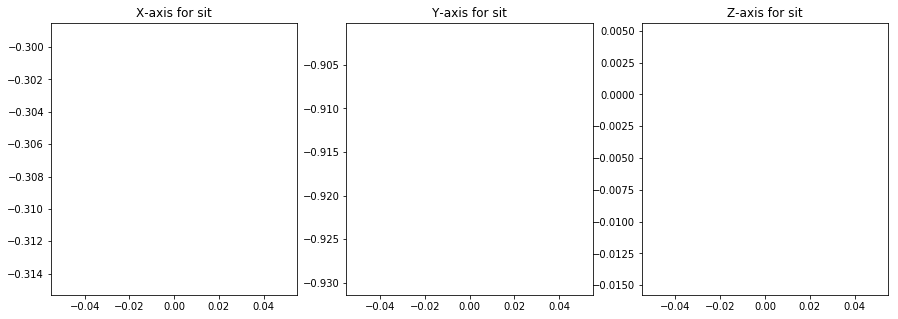

('plotting ', 'sleep')


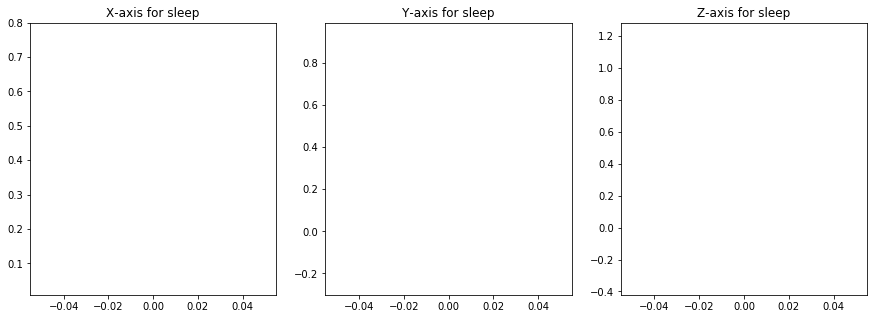

('plotting ', 'stand')


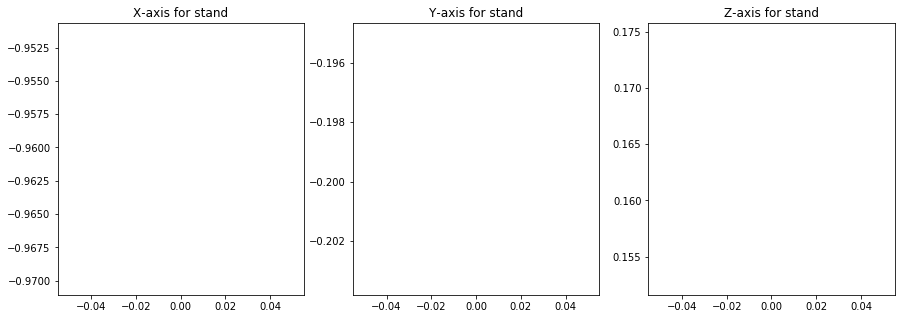

('plotting ', 'downstairs')


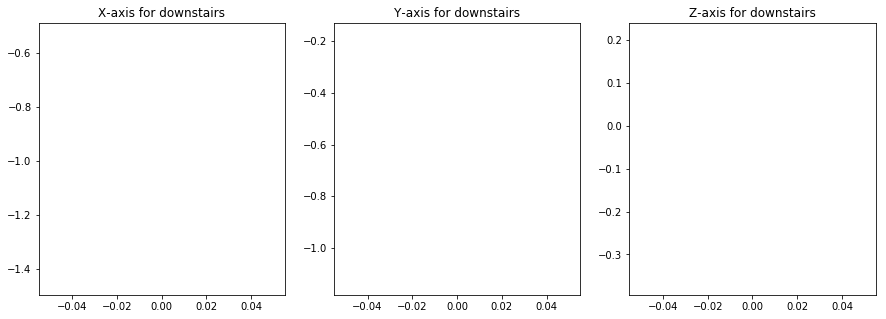

('plotting ', 'upstairs')


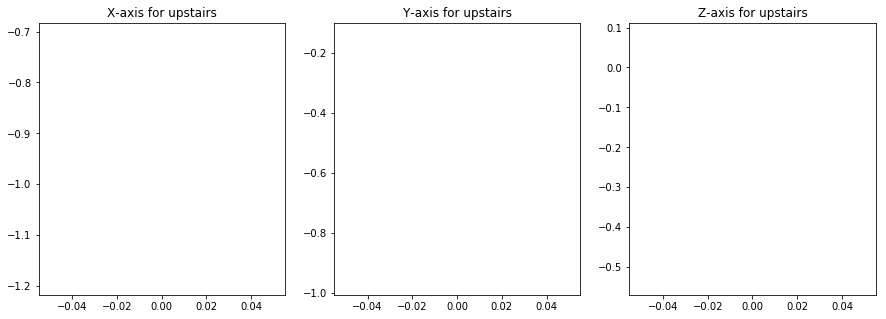

('plotting ', 'walk')


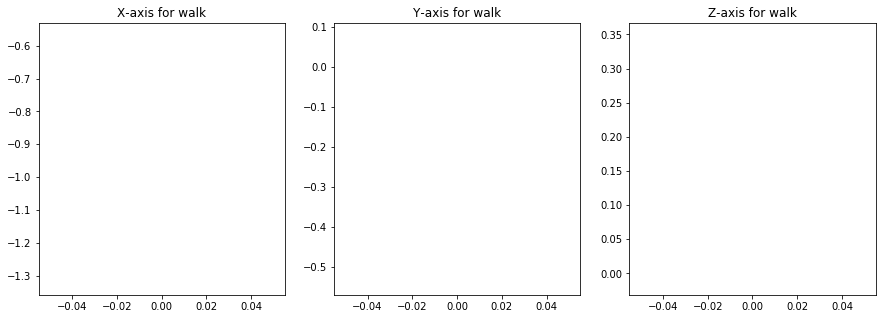

In [47]:
plot_all_label(X_label, y_all, new_label_list, new_label_dict)

In [48]:
# denoise the signal using wavelet transform
wavelet_output = wavelet_smooth(X_all)

X_w = np.array(wavelet_output)

PCA
[[ 0.85719117  0.0561324   0.51193012]
 [ 0.09262149  0.96103062 -0.26046382]
 [-0.50660098  0.27068302  0.8185879 ]]


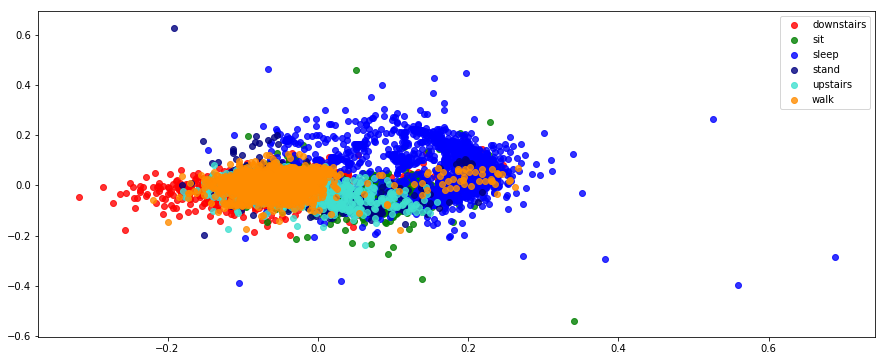

[[-0.0319249   0.95975013  0.27903492]
 [ 0.98835745 -0.01123825  0.15173416]
 [ 0.14876274  0.28063034 -0.94821741]]


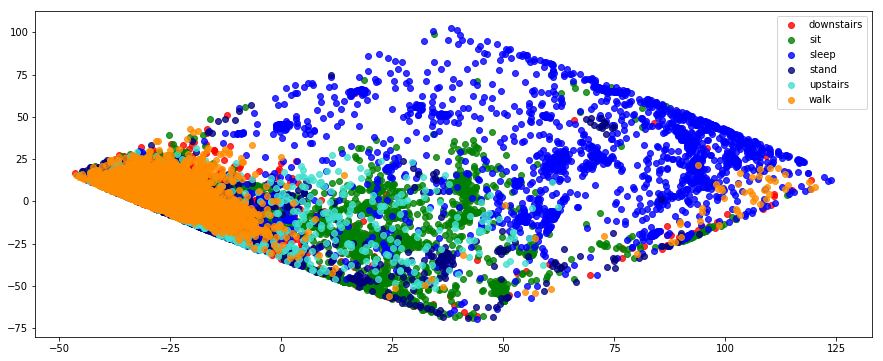

LDA


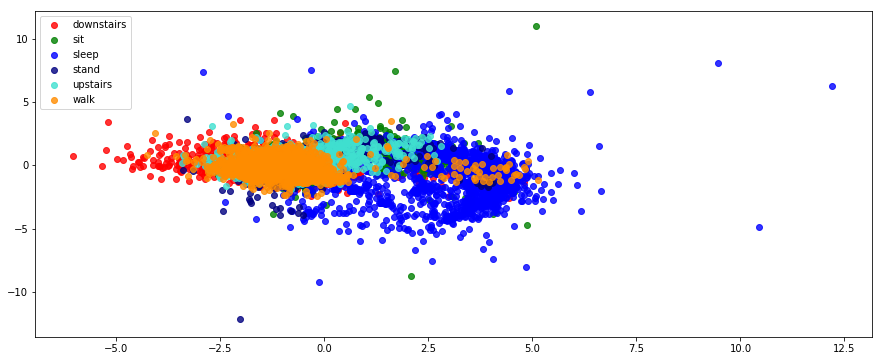

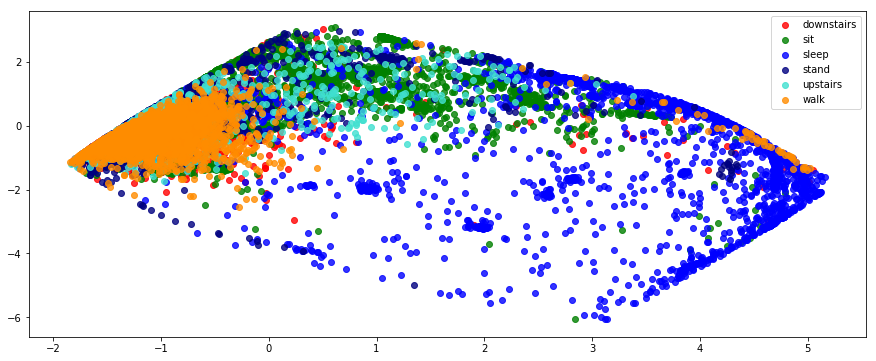

SVD
((19931L, 3L), (3L,), (3L, 3L))
[ 96.53601348  10.06456176   7.8550971 ]


In [49]:
colors = ['r','g','b','navy','turquoise','darkorange']

# calculate roll, pitch, yaw and stack them into a list: rpy_list
roll, pitch, yaw = calc_rpy(X_w, subject_id, colors)
rpy = np.array([roll, pitch, yaw]).transpose()

# normalize X_w so we get X_norm
X_norm = np.array(normalize_data(X_w))

# apply PCA and LDA to X_norm and rpy
print("PCA")
X_norm_pca = apply_pca(X_norm, y_all, label_list)
rpy_pca = apply_pca(rpy, y_all, label_list)

print("LDA")
X_norm_lda = apply_lda(X_norm, y_all, label_list)
rpy_lda = apply_lda(rpy, y_all, label_list)

# apply svd to X_norm and rpy
print("SVD")
u, s, vh = apply_svd(X_norm, y_all, label_list)
u_r, s_r, vh_r = apply_svd(X_norm, y_all, label_list)

print(u_r.shape, s_r.shape, vh_r.shape)
print(s_r)

In [50]:
# reshape data before classification
X_svm = np.vstack((X_norm_pca, rpy_pca))
y_svm = y_all
y_svm = y_svm.reshape((y_svm.shape[-1],))
y_svm = np.hstack((y_svm, y_svm))
y_svm = y_svm.reshape((y_svm.shape[0],))

print(X_svm.shape, y_svm.shape)

((39862L, 3L), (39862L,))


In [51]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42)

In [82]:
from sklearn.metrics import classification_report

In [84]:
# Using SVM to classify activities
h = .02
nn_model = nn_classifier(X_svm, y_svm)
nn_model2 = nn_classifier2(X_svm, y_svm)
nn_model3= nn_classifier3(X_svm, y_svm)
print("Finished classification")
    
y_pred = nn_model.predict(X_test)
y_pred2 = nn_model2.predict(X_test)
y_pred3 = nn_model3.predict(X_test)

print(classification_report(y_test, y_pred, target_names=LABELS))
#acc = accuracy_score(y_test, y_pred)
#acc2 = accuracy_score(y_test, y_pred2)
#acc3 = accuracy_score(y_test, y_pred3)

#print("Ball_tree",acc)
#print("Kd_tree",acc2)
#print("Brute",acc3)

Finished classification
             precision    recall  f1-score   support

 downstairs       0.50      0.52      0.51      1281
        sit       0.85      0.93      0.89      2276
      sleep       0.93      0.92      0.93      2227
      stand       0.78      0.86      0.82      3260
   upstairs       0.43      0.14      0.21       596
       walk       0.66      0.61      0.64      2319

avg / total       0.75      0.77      0.75     11959



# Confusion matrix

In [80]:
from sklearn.metrics import confusion_matrix
import itertools

Confusion matrix, without normalization
[[ 662   59   29  201   20  310]
 [  36 2108   50   40   11   31]
 [  39   90 2055   15   10   18]
 [ 151   63   19 2818   24  185]
 [ 118   88   14  112   85  179]
 [ 318   61   43  426   47 1424]]
Normalized confusion matrix
[[ 0.52  0.05  0.02  0.16  0.02  0.24]
 [ 0.02  0.93  0.02  0.02  0.    0.01]
 [ 0.02  0.04  0.92  0.01  0.    0.01]
 [ 0.05  0.02  0.01  0.86  0.01  0.06]
 [ 0.2   0.15  0.02  0.19  0.14  0.3 ]
 [ 0.14  0.03  0.02  0.18  0.02  0.61]]


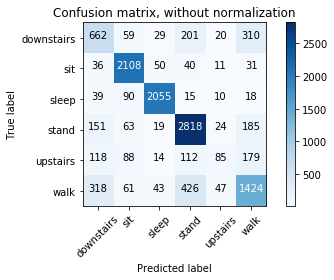

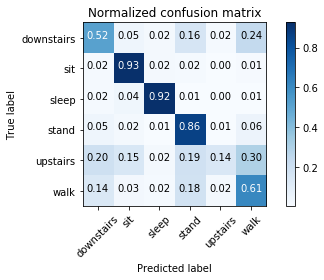

In [81]:
n_classes = 6
LABELS = ['downstairs','sit','sleep','stand','upstairs','walk']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

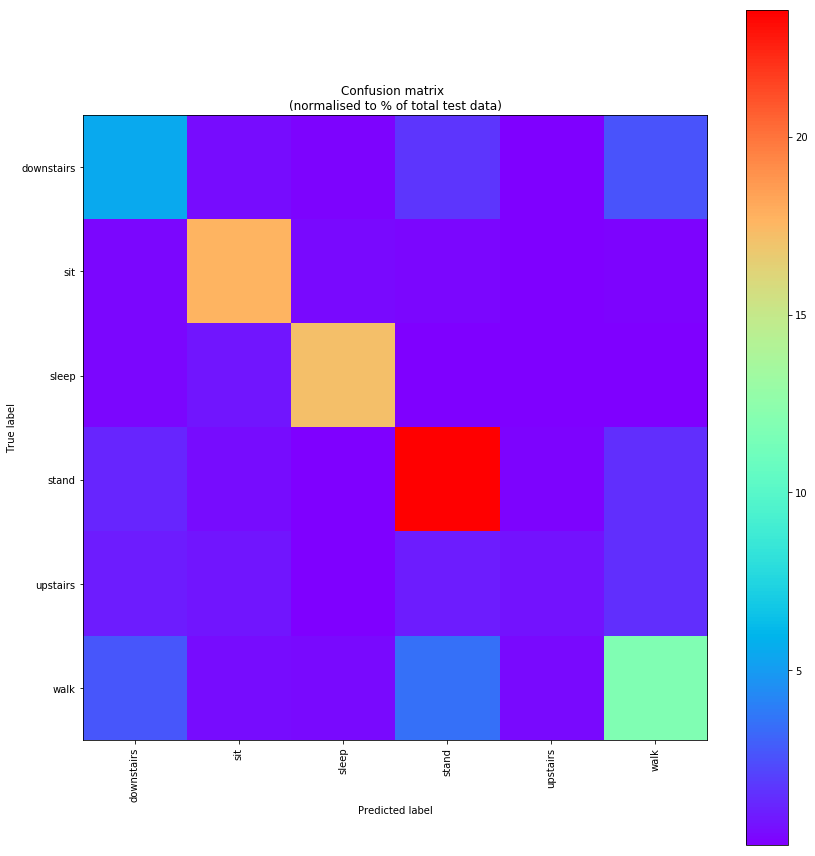

In [68]:
n_classes = 6
LABELS = ['downstairs','sit','sleep','stand','upstairs','walk']
cm = confusion_matrix(y_test, y_pred)
normalised_confusion_matrix = np.array(cm, dtype=np.float32)/np.sum(cm)*100
# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [76]:
nn_model4 = nn_classifier(X_svm, y_svm)

x_min, x_max = X_svm[:, 0].min() - 1, X_svm[:, 0].max() + 1
y_min, y_max = X_svm[:, 1].min() - 1, X_svm[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = nn_model4.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("6-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

ValueError: query data dimension must match training data dimension

            'downstairs' 'sit' 'sleep' 'stand' 'upstairs' 'walk'

'downstairs'

'sit'

'sleep'

'stand'

'upstairs'

'walk'

-------------------------
### 1001
* Accuracy of original data: 0.6356

* Accuracy of PCA with original data: 0.6041

* Accuracy of PCA without original data: 0.6400
-------------------------
### All subjects ( test_size=0.3 )
* Accuracy of PCA without original data: 0.6542

## Color Note

* NaN: Grey
* Stand: Red
* Sit: Green
* Sleep: Yellow
* Walk: Blue
* Walk Downstairs: Orange
* Walk Upstairs: Purple

# Evaluate the Algorithms

## Walking

### Calculate Walking Range

In [ ]:
def exact_walk_range(timer_filt):
  # Retrieve exact walking time periods from the csv file in timestamp (seconds) form
    walk_lbl = ['walk','downstairs','upstairs']

    w_times = [t for t in timer_filt['label'] for lb in walk_lbl if t==lb]
    walk_times = timer_filt[timer_filt['label'].isin(w_times)]
    walk_times = walk_times.reset_index(drop=True)

    walks = walk_times[['timestamp','duration']].to_dict()

    all_walks = []

    for i in range(len(walk_times)):
        tmstmp = walk_times.loc[i]['timestamp'].split(' ')[1]
        durat = walk_times.loc[i]['duration']
        all_walks.append(period(calc_sec(tmstmp), calc_sec(tmstmp) + calc_sec(durat)))

    exact_range = []
    for x in all_walks:
        exact_range.append(range(math.floor(x.s), math.ceil(x.f)))

    return exact_range

In [ ]:
def pred_walk_range(df1, walk_its_p):
    # Get predicted walking time periods in timestamp (seconds) form
    all_walks_pred = []

    for x in walk_its_p:
        tsp1 = df1.loc[x.s]['timestamp'].split(' ')[1]
        tsp2 = df1.loc[x.f]['timestamp'].split(' ')[1]

        all_walks_pred.append(period(calc_sec(tsp1), calc_sec(tsp2)))

    pred_range = []
    for x in all_walks_pred:
        pred_range.append(range(math.floor(x.s), math.ceil(x.f)))

    return pred_range

In [ ]:
def overlap_walk(exact_range, pred_range):
    # Calculate range of overlap
    overlap_sets = []

    for e in exact_range:
        for p in pred_range:
            overlap_sets.append(set(e).intersection(p))

    overlap_list = []

    for x in overlap_sets:
        if(len(x)!=0):
            l = list(x)
            ll = sorted(l)

            overlap_list.append(period(ll[0],ll[-1]))

    overlap_dur = 0
    for x in overlap_list:
        overlap_dur += x.f - x.s

    print(overlap_dur)

    return overlap_dur

In [ ]:
def union_walk(exact_range, pred_range):
  # Calculate range of union
    union_sets = []

    for e in exact_range:
        for p in pred_range:
            union_sets.append(set(e).union(p))

    union_set_2 = set()

    for x in union_sets:
        union_set_2 = union_set_2.union(x)

    # print(union_set_2)

    l = list(union_set_2)
    ll = sorted(l)

    union_list = []
    keep = ll[0]

    for i in range(len(ll)):
        if(i>0 and ll[i]-ll[i-1]>1):
            union_list.append(period(keep,ll[i-1]))
            keep = ll[i]

    union_dur = 0
    for x in union_list:
        union_dur += x.f - x.s

    print(union_dur)

    return union_dur

### Evaluate with IoU *

In [ ]:
# exact_range = exact_walk_range(df_timer)
# pred_range = pred_walk_range(df1, walk_its_p)

# overlap_dur = overlap_walk(exact_range, pred_range)
# union_dur = union_walk(exact_range, pred_range)

# IoU = overlap_dur/union_dur
# print("IoU for", subject_id, ":", IoU)

In [ ]:
# Still incomplete (have to remove NaN)**

In [ ]:
'''
    # classify walking
    walk = calc_walk(df1)
    walk_its = intersection_walk(walk)
    walk_its_p = calc_walk_periods(walk_its)

    plot_walk(df1, ai1, walk_its_p)

    # classify inactive
    s = calc_inactive(ai1)
    sequence = get_sequence(s)

    plot_inactive(df1, ai1, sequence)
'''

Headings with [ * ] are the ones where functions are called.

## ** Note **
* **IoU for 1002 : 0.8412698412698413**

* **IoU for 1003 : 0.5524861878453039**